<a href="https://colab.research.google.com/github/OwenHuels/data-science/blob/main/OwenHuelU3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "preliz[full,notebook]"


import preliz as pz


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.

#**Unit 3 Project: LASA Ultimate Frisbee Throws per Point**

##**Context**

In the Unit 2 Project, I attempted to answer the question of what LASA's O-Line winning percentage will be this coming season. While this predicted percentage is a good indicator of just the binary win loss outcome of our points, that doesn't tell the whole story of how we got there.

Each point in Ultimate consists of players throwing the disc between eachother up the field, attempting to reach the opposing endzone. Players may not move while they are holding the disc. If a team is attempting few throws per point, that means they are playing at a rapid pace. More throws means a slower pace.

Combining this metric with point winning percentages can tell us how efficiently and quickly LASA is able to score their points, making it more clear when games are less close or more close than the score implies.

This leads us to what we are going to attempt to model, which is the true distribution that models the numbers of throws per point by LASA's Ultimate team.

([link to data for those curious](https://docs.google.com/spreadsheets/d/1wiDukWq9TPsweVTVjoAfB0nxHVuJqiG9w1ys5b5rdEM/edit?usp=sharing))

##**Data**

Before we begin to create and test models, here is the raw data and visualization.

In [ ]:
#raw data csv from my github
url_throws = 'https://raw.githubusercontent.com/OwenHuels/data-science/main/OwenHuelU3projDataCSV%20-%20Sheet1.csv'

data_throws = pd.read_csv(url_throws)

#view data
data_throws

,24
0,7
1,1
2,23
3,5
4,8
...,...
131,1
132,11
133,27
134,4


As you can see, this **data is discrete**. However, I will be using **continuous functions for my models**. Continuous distributions are ok to be used with discrete data, so long as you're willing to group the final resulting data back into the bins (in this case discrete, nonnegative integers) that it came in. I might also like to predict information about attempted throws that were failed based on how far they got to their target (for example, 10.5 throws would be 10 throws attempted and completed, followed by one more attempt that got halfway to its target), and a continuous distribution allows me to do this effectively whereas a discrete distribution is unable.

(array([87., 29.,  9.,  4.,  1.,  2.,  2.,  1.,  0.,  1.]),
 array([ 0. ,  8.2, 16.4, 24.6, 32.8, 41. , 49.2, 57.4, 65.6, 73.8, 82. ]),
 <BarContainer object of 10 artists>)

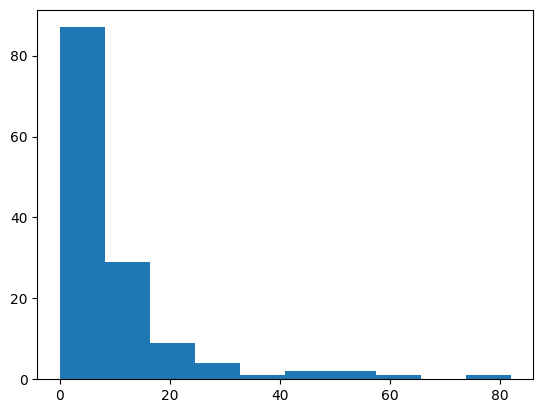

In [ ]:
#data histogram visualization
plt.hist(data_throws)

The histogram shows most of the data concentrated below 20, with a flattening curve going off to the right. Only non-negative values are in the support of this data. There are outliers to the right, I assume moreso than to the left. The mean is at about 10.

##**Models** *(a lot of, possibly too many, models)*

This data looks pretty exponential to me, so the first likelihood I'm going to try will be an exponential distribution. The data only contains 0 and positive numbers, so the support of an exponential lines up with that. We wouldn't want to return negative numbers. The exponential likelihood requires one prior, lambda. I think that the average number of throws per point should be around 10 based on my experience, and the mean of an exponential distribution is one over lambda, so I'll choose a Gamma distribution with mean of one over 10 as my prior for lambda, because lambda can't be negative. Alpha = 2 and beta = 20 works for this.

<Axes: >

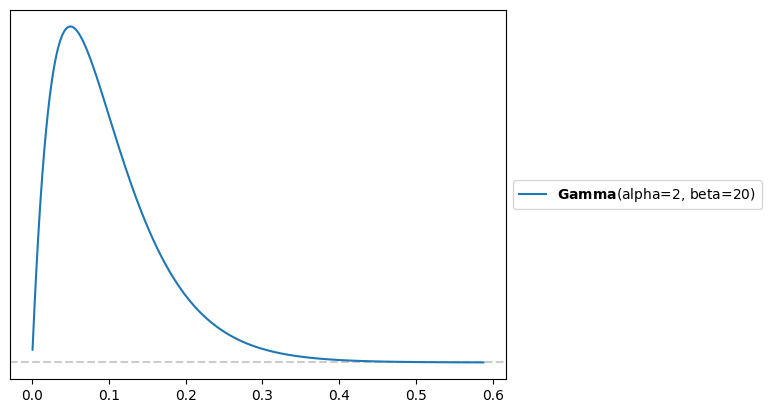

In [ ]:
#gamma distribution for prior for lambda
pz.Gamma(alpha = 2, beta = 20).plot_pdf()

Now for the model:

In [ ]:
#E for exponential
with pm.Model() as model_throwsE:
   #I think lambda should be around 1/10
   l = pm.Gamma('l', alpha=2, beta=20)

   #likelihood
   Y = pm.Exponential('Y', lam=l, observed=data_throws)
   idata_throwsE = pm.sample()

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(idata_throwsE, model=model_throwsE, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 80.0)

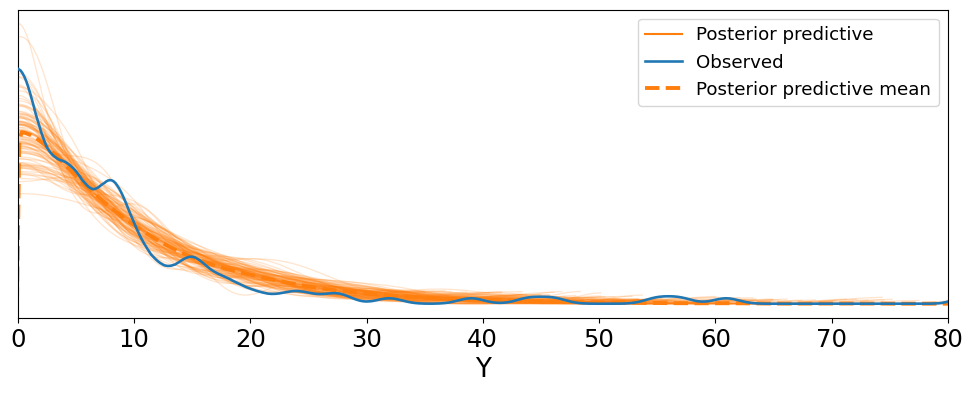

In [ ]:
#Plots the posterior predictive density overlaid with a smoothed version of the data

ax = az.plot_ppc(idata_throwsE, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#need to limit the x axis, so its more readable
ax.set_xlim(0, 80)

This model is okay overall. It seems to align with the data relatively well, although it consistent overestimates by a bit near the ends and underestimates near the peak. However, the more pressing issue that I noticed was the behavior of our model as we approach 0. Our data contains 0s in it, so our likelihood should have support that includes 0. This means that the exponential likelihood isn't the best choice for our data because while it does support 0, it goes towards infinity there, so we'll have to pick something else.

The distribution that nicely fixes both of these problems is the half studentT distribution. We want to mess with the kurtosis in order to fix the problem we had of overestimating outliers and underestimating the peak, and the normality paramater nu of the Half Student's T distribution allows us to do this. Half Student's T has a support of $[0, \infty)$, so we're good to go on that front. It also has a nice value at 0 rather than going off to infinity there, which fixes our other issue.

For a Half Student's T distribution, we need the paramaters nu and sigma.

For nu, we want the distribution to still be mostly normal, but with a bit of leeway, so I'll use an exponential distribution for the nu prior with lamda as 1/30. The exponential distribution means we can get very non-normal distributions, but our expected value for nu is still pretty high (higher is more normal).

For sigma, I'll use a halfnormal distribution to avoid massive standard deviation values. Standard deviation has to be positive, which is why we use halfnormal instead of just normal for its prior. I'm not sure what sigma should be for this distribution, so I'll just use 5.

<Axes: >

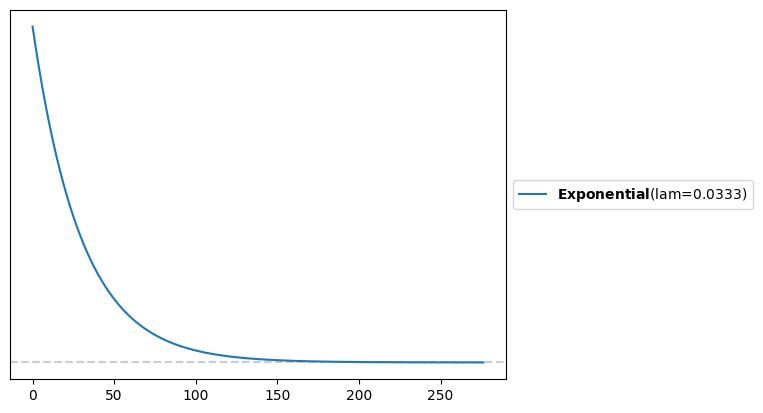

In [ ]:
pz.Exponential(lam = 1/30).plot_pdf()

<Axes: >

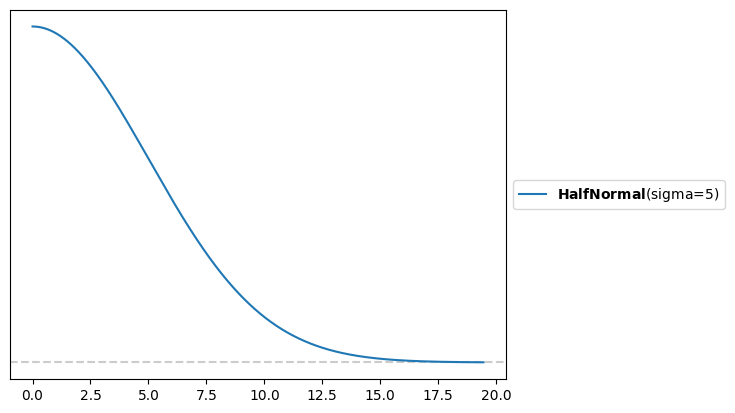

In [ ]:
pz.HalfNormal(sigma = 5).plot_pdf()

In [ ]:
#T is for Half Student's T distribution
with pm.Model() as model_throwsT:

    #half normal for the standard deviation
    σ = pm.HalfNormal('σ', sigma=5)

    #this is our normality parameter; lam = 1/30 gives a mean of 30
    ν = pm.Exponential('ν', lam=1/30)

    #new likelihood, same data
    y = pm.HalfStudentT('y', sigma=σ, nu = ν, observed=data_throws)
    idata_throwsT = pm.sample()

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(idata_throwsT, model=model_throwsT, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 80.0)

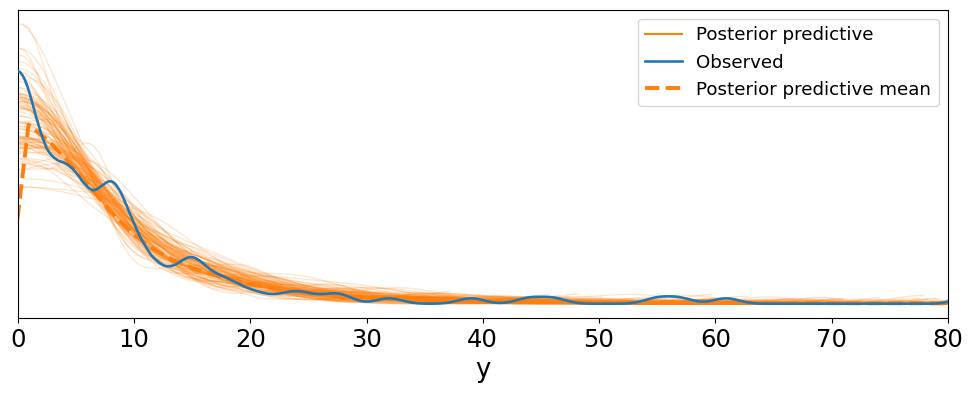

In [ ]:
#Plots the posterior predictive density overlaid with a smoothed version of the data

ax = az.plot_ppc(idata_throwsT, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#need to limit the x axis, so its more readable
ax.set_xlim(0, 80)

This distribution is ok, but I don't think it's as good as the exponential, so I think I can do better. The posterior predictive mean tails off weirdly when going towards 0, and also consistently underestimates near the peak of the graph.

The next distribution I'll try is the Gamma distribution, which I used for one of my priors earlier. Gamma requires two priors, mu and sigma.

For mu (mean), I think that the average of my data is around 10, so I'll use another Gamma distribution with alpha as 10 and beta as 1 for this prior, because I'm not really sure what the standard deviation should be. I want the mean to definitely be positive though, so a Gamma distribution is good for that.

For sigma (standard deviation), I'll use a Uniform for my prior. I'm not super confident in my guess for what the standard deviation should be, but I think it's probably between 5 and 20, so a Uniform distribution is helpful here.



In [ ]:
#G is for Gamma distribution
with pm.Model() as model_throwsG:

    #half normal for the standard deviation
    σ = pm.Uniform('σ', lower=5, upper=20)

    #this is our mean
    #alpha = 10 and beta = 1 gives a mean of 10 and somewhat large stddev
    μ = pm.Gamma('μ', alpha=10, beta=1)

    #new likelihood, same data
    a = pm.Gamma('a', mu=μ, sigma=σ, observed=data_throws)
    model_throwsG.debug()
    idata_throwsG = pm.sample()

point={'σ_interval__': array(0.), 'μ_log__': array(2.30258509)}

The variable a has the following parameters:
0: True_div [id A] <Matrix(float64, shape=(1, 1))>
 ├─ Sqr [id B] <Matrix(float64, shape=(1, 1))>
 │  └─ Exp [id C] <Matrix(float64, shape=(1, 1))>
 │     └─ ExpandDims{axes=[0, 1]} [id D] <Matrix(float64, shape=(1, 1))>
 │        └─ μ_log__ [id E] <Scalar(float64, shape=())>
 └─ Sqr [id F] <Matrix(float64, shape=(1, 1))>
    └─ ExpandDims{axes=[0, 1]} [id G] <Matrix(float64, shape=(1, 1))>
       └─ Check{sigma > 0} [id H] <Scalar(float64, shape=())>
          ├─ Add [id I] <Scalar(float64, shape=())> 'σ'
          │  ├─ Mul [id J] <Scalar(float64, shape=())>
          │  │  ├─ 20.0 [id K] <Scalar(float64, shape=())>
          │  │  └─ Sigmoid [id L] <Scalar(float64, shape=())>
          │  │     └─ σ_interval__ [id M] <Scalar(float64, shape=())>
          │  └─ Mul [id N] <Scalar(float64, shape=())>
          │     ├─ 5.0 [id O] <Scalar(float64, shape=())>
          │     └─ 

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'σ_interval__': array(0.49924826), 'μ_log__': array(1.32779414)}

Logp initial evaluation results:
{'σ': -1.45, 'μ': -3.3, 'a': -inf}
You can call `model.debug()` for more details.

This model is unable to run. When I tried with an Exponential distribution for my likelihood, it looked pretty good. When alpha is slightly bigger than 1 for a Gamma distribution, it looks like an Exponential distribution but without the behavior of going off to infinity at 0. My priors for the model I just tried create alpha values way far away from 1, which isn't what we want. I'll now try a Gamma distribution, but paramaterized with alpha and beta rather than mu and sigma

For my alpha (shape parameter) prior, as mentioned previously, I want the value to be close to one. I'm not really sure exactly how far it should be from one, so I'll use a Uniform distribution with a lower bound of 1.00001 and and upper bound of 3. The Uniform means that I'm equally fine with any value in that range.

For my beta (size parameter) prior, I know that I want my data to spread pretty far out, let's say from 0 to 100. This happens when beta is a really small number. I'll use a HalfNormal distribution for this prior, which I want to be very small numbers. Sigma equals 0.05 keeps the beta value under 0.2, so I'll use that, because beta = 0.2 allows for a range of values that is a bit less than what I want.

In [ ]:
#GE is for Gamma (similar to exponential) distribution
with pm.Model() as model_throwsGE:

    #uniform for alpha
    a = pm.Gamma('a', sigma=0.5, mu=2)

    #half normal for beta
    b = pm.Gamma('b', sigma=0.025, mu=0.2)

    #new likelihood, same data
    g = pm.Gamma('g', alpha=a, beta=b, observed=data_throws)
    idata_throwsGE = pm.sample()

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'a_log__': array(0.97167693), 'b_log__': array(-2.20280644)}

Logp initial evaluation results:
{'a': -0.22, 'b': -8.17, 'g': -inf}
You can call `model.debug()` for more details.

This model is also unable to run. I forgot that Gamma doesn't have a support that includes 0 (whoops), so the fact that my data includes 0 causes problems.

At this point I realized that the Half Student's T could be fixed by changing the normality the parameter. I think that the weird behavior of the posterior predictive mean is just a visual or computational error, because the actual individual sample line up with my observed data really well.

For sigma (standard deviation), I'll use the same prior as before (Half Norma with sigma = 5).

For nu (normality), I'm going to try to give the model room to allow for less normality. Instead of an Exponential with lambda = 1/30, I'll use an Exponential with lambda = 1/10. The mean is one over lambda, and a smaller number is less normal.

<Axes: >

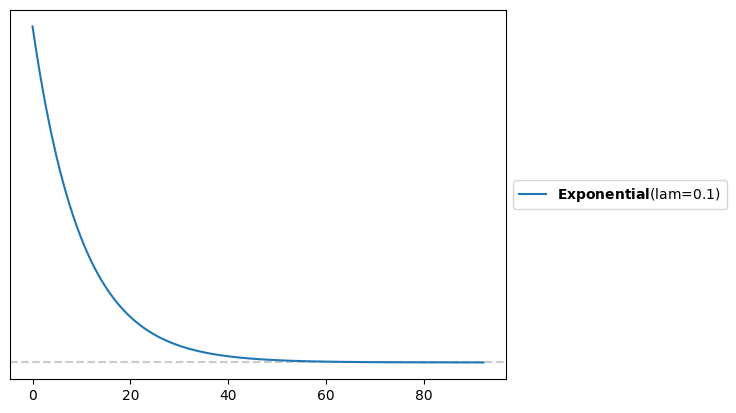

In [ ]:
pz.Exponential(lam=1/10).plot_pdf()

In [ ]:
#T is for Half Student's T distribution
with pm.Model() as model_throwsT:

    #half normal for the standard deviation
    σ = pm.HalfNormal('σ', sigma=5)

    #this is our normality parameter; lam = 1/10 gives a mean of 10
    ν = pm.Exponential('ν', lam=1/10)

    #new likelihood, same data
    y = pm.HalfStudentT('y', sigma=σ, nu = ν, observed=data_throws)
    idata_throwsT = pm.sample()

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(idata_throwsT, model=model_throwsT, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 80.0)

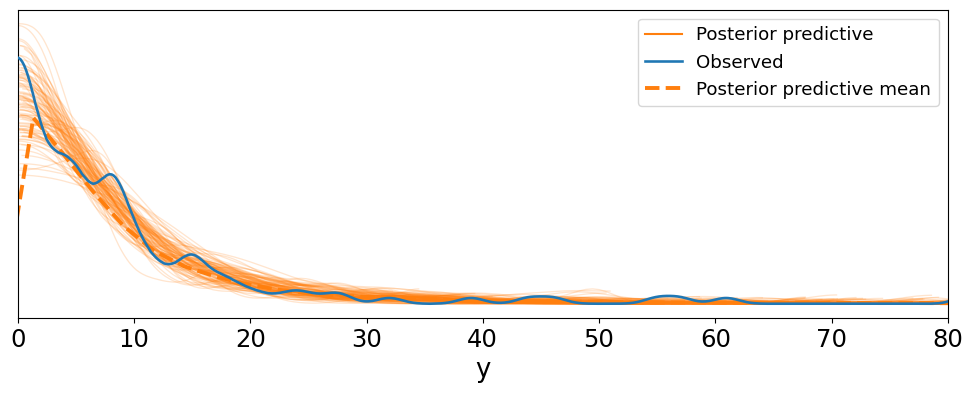

In [ ]:
#Plots the posterior predictive density overlaid with a smoothed version of the data

ax = az.plot_ppc(idata_throwsT, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#need to limit the x axis, so its more readable
ax.set_xlim(0, 80)

array([<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

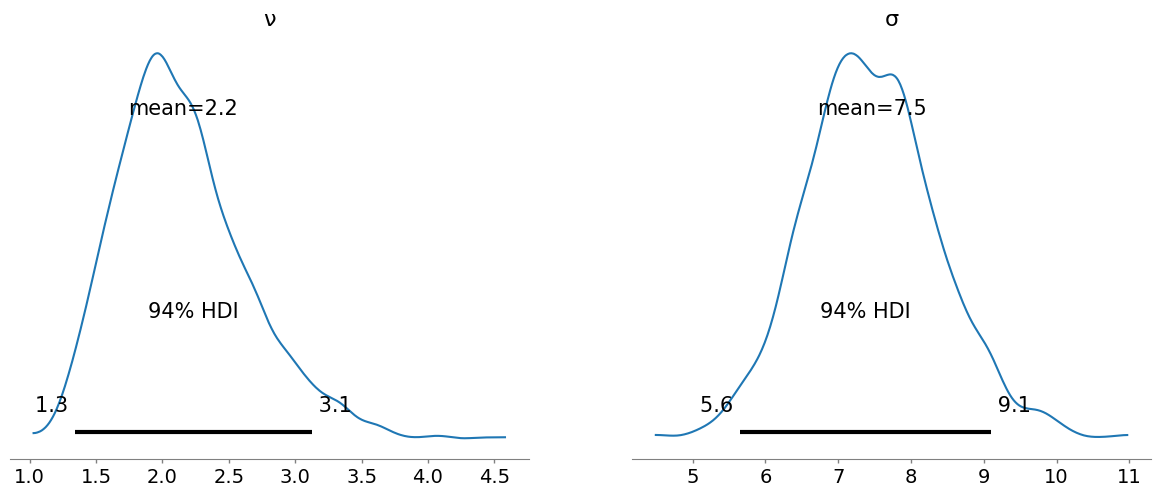

In [ ]:
az.plot_posterior(idata_throwsT)

##**Conclusion**

There you have it: This final model, using a Half Student's T distribution for the likelihood, a Half Normal distribution for the sigma prior, and an Exponential distribution for the nu prior, fits my data well.

Someting important to note: A Half Student's T distribution is literally just half a Student's T distribution (obviously), which means that it's kind of a "fake" distribution. It's very, very good at predicting outcomes based on the data I've collected, but because of the fact that there's no statistical ground behind this model, it doesn't tell us anything about the process that is generating this data and how to understand that. For example of this odd behavior, the Half Student's T distribution does not have a defined mean.

The model that I tried first, with an Exponential distribution for the likelihood, modeled the data somewhat well, albeit not as well as the Half Student's T. While it may not have as much predicitive power, it does have the advtange of having an actual meaning behind the distribution. The Exponential distribution is a specified form of the Gamma distribution, and the discrete "equivalent" of a Gamma distribution is the Poisson. My data was discrete originally, so if we look at the Poisson distribution's generation process, it can give us an idea of where my data is coming from. The process behind it is that it models the number of independent events that occur in a fixed period of time. While the length of a point of frisbee may not be entirely fixed, individual points tend to last around the same amount of time, so it makes sense that the number of throws (which we'll assume are independent) within a point (a semi set amount of time) can be modeled this way.

I'm more interested in getting raw predictive power out of my model that to understand the underlying process, so that's why I chose the Half Student's T as my final answer. These two models have different advtanges though, so if you wanted to go with the other one, be my guest.

The blue line (observed data) is entirely enclosed within the different samples taken from the posterior predictive check, so it seems like the data has been modeled relatively well.

A Student's T Distribution tends to fit data with a small sample size well, so it makes sense that it would fit my data of only around 130 instances (which isn't that many in the grand scheme of things). A Student's T Distribution also allows room for more outliers, which my data definitely has a lot of.

One major flaw of this model is the fact that your number of throws per point in Ultimate is heavily affected by the team you are playing. In a theoretically perfect game, you and your opponent would takes turns starting on offense and never turn over the disc, so you would have 0 throws every other point. This means that the better your opponent's offense, the better your offense looks because you have all of those 0's dragging the number of throws per point down, which shouldn't really be a factor. To fix this, I could model the number of throws per posession rather than per point.

Overall, I feel that this model is ok, but could be improved significantly. I'd like to try, if possible, to use a discrete likelihood rather than a continuous likelihood to see what happens. I'm not sure if it would be a better model or not, but it would definitely be interesting to try.

If you want to make a guess for what the number of throws in a point would be, it looks like anything between 0 and 20 would be a relatively reasonable selection. I'm partial to around 15 because at the high school level, most teams aren't playing perfect points and are turning the disc over at least once a point, so a higher estimate seems fair to me.